# Red Wine Quality Analysis

The Red and White Wine Quality data sets are available in UCI. Please refer to the abstract, problem statement and data sets description at https://archive.ics.uci.edu/ml/datasets/Wine+Quality. Each data set contain 12 features including `quality` as the target variable.

## Notebook Abstract

In this notebook, we have considered only the Red Wine quality data set.

In the problem statement, the authors state _"we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods."_

Accordingly, we have attempted to determine the accuracy of predictions using different subsets of the features. We have developed four Machine Learning Models and compared the accuracy of predictions resulting from each model. For each ML technique, we have considered (a) the complete set of 11 features (b) dropped 3 features that show very weak correlation i.e., `0.0-0.20` and (c) dropped an additional 5 features exhibiting weak correlation i.e., `0.20-0.40` with the target. In short 12 models have been developed.

We find that predictions using Linear Regression exhibit the best accuracy of about 92% even with just three features. This may be due to the 'privacy and logistics issues' mentioned by the data set authors.

Predictions made using Logistic Regression, Decision Tree and Random Forest yield poor accuracy between 50-70% even when K-fold and Grid Search CV methods are used to improve the predictions.

## Git Repo

The git repo contains the red wine dataset and code for a Flask app for deploying the red wine quality models on your local machine. For deploying on Heroku, the `requirements.txt` and `Procfile` are also provided.

## Next Steps

Red Wine quality prediction appears to depend on just three feature with minimal loss of prediction accuracy on the test set. This may be due to the privacy and logistics issues mentioned by the data set authors (e.g. there is no data about grape types, wine brand, wine selling price, etc.) or it may be due to other domain related factors that are not clear.

Other ML techniques may be applied to improve the accuracy.

## Machine Learning Pipeline

Developing an ML model involves a number of steps.

We have adopted the following Machine Learning Pipeline:

1. Sanity Check 
2. EDA/Preprocessing
3. Feature Engineering
4. Model Building
5. Model Saving
6. Model Deployment - this is covered under the `deployment` folder

Once the model is deployed, the pipeline _extends_ to include the below steps:

7. Model in Production
8. Observe model behaviour
9. Obtain updated datasets
10. Redo steps 1..9 if required

_Note: these extended steps 7-10 are not covered in this exercise_

## Common Steps Performed on the Red Wine Dataset

In [1]:
#import the relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV


In [2]:
# read the dataset
fpath = '../input/red-wine/winequality-red.csv'
red_wine_data = pd.read_csv(fpath, delimiter =';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Sanity Check
_Insights are drawn at the end of this section._

In [3]:
#1. Shape and data sufficiency: Check if there are sufficient rows of data for an ML problem
red_wine_data.shape

(1599, 12)

In [4]:
# 2. Datatypes: Check the datatypes of each column; later, convert non-numeric columns to numeric
red_wine_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [5]:
# 3 Missing Values: Check whether there are missing values
red_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
# 4 Zero-variance: Check if there are any zero variance column in the dataset
for col in red_wine_data:
    print(col, red_wine_data[col].value_counts().count())

fixed acidity 96
volatile acidity 143
citric acid 80
residual sugar 91
chlorides 153
free sulfur dioxide 60
total sulfur dioxide 144
density 436
pH 89
sulphates 96
alcohol 65
quality 6


In [7]:
# 5 Range of numbers in each column: Check the range of variation in each numeric column 
for i in red_wine_data.columns:
    print("range of {}: ({}, {}) " .format(i, red_wine_data[i].min(), red_wine_data[i].max()))

range of fixed acidity: (4.6, 15.9) 
range of volatile acidity: (0.12, 1.58) 
range of citric acid: (0.0, 1.0) 
range of residual sugar: (0.9, 15.5) 
range of chlorides: (0.012, 0.611) 
range of free sulfur dioxide: (1.0, 72.0) 
range of total sulfur dioxide: (6.0, 289.0) 
range of density: (0.99007, 1.00369) 
range of pH: (2.74, 4.01) 
range of sulphates: (0.33, 2.0) 
range of alcohol: (8.4, 14.9) 
range of quality: (3, 8) 


inconclusive effect of fixed acidity on quality.


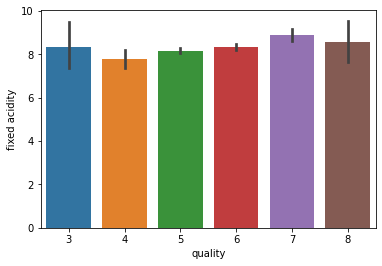

In [8]:
# 6 Correlation: Check correlation between feature columns & target

# 6a check how the quality is influenced by fixed acidity
# e.g., does higher quality mean higher fixed acidity?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['fixed acidity'])
print('inconclusive effect of fixed acidity on quality.')

volatile acidity shows decreasing trend as the quality increases.


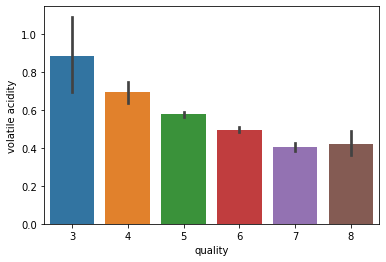

In [9]:
# 6b check how the quality is influenced by volatile acidity
# e.g., does higher quality mean higher volatile acidity?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['volatile acidity'])
print('volatile acidity shows decreasing trend as the quality increases.')

quality increase as citric acid increases.


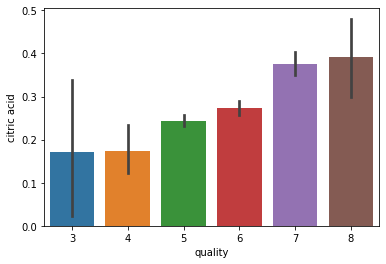

In [10]:
# 6c check how the quality is influenced by citric acid
# e.g., does higher quality mean higher citric acid?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['citric acid'])
print('quality increase as citric acid increases.')

inconclusive/minimal effect of residual sugar on quality.


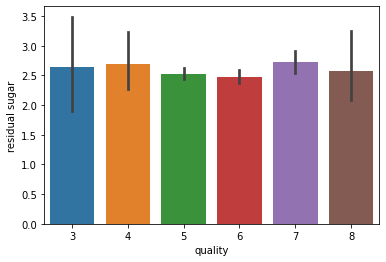

In [11]:
# 6d check how the quality is influenced by residual sugar
# e.g., does higher quality mean higher residual sugar?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['residual sugar'])
print('inconclusive/minimal effect of residual sugar on quality.')

chlorides decreases as quality increases.


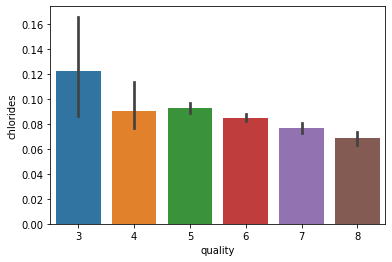

In [12]:
# 6e check how the quality is influenced by chlorides
# e.g., does higher quality mean higher chlorides?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['chlorides'])
print('chlorides decreases as quality increases.')

free sulfur dioxide increases with quality and peaks at 5 before decreasing.


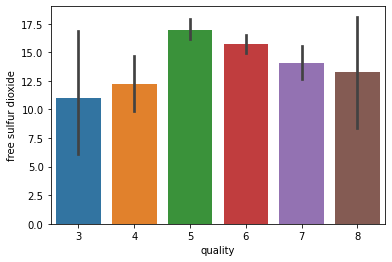

In [13]:
# 6f check how the quality is influenced by free sulfur dioxide
# e.g., does higher quality mean higher free so2?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['free sulfur dioxide'])
print('free sulfur dioxide increases with quality and peaks at 5 before decreasing.')

total sulfur dioxide increases with quality and peaks at 5 before decreasing.


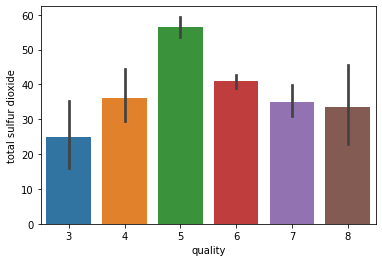

In [14]:
# 6g check how the quality is influenced by total sulfur dioxide
# e.g., does higher quality mean higher total so2?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['total sulfur dioxide'])
print('total sulfur dioxide increases with quality and peaks at 5 before decreasing.')

density has minimal effect on quality.


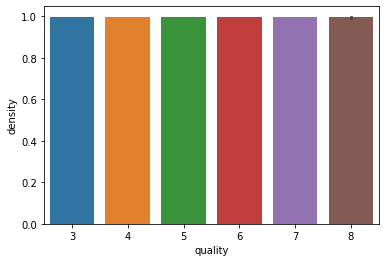

In [15]:
# 6h check how the quality is influenced by density
# e.g., does higher quality mean higher density?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['density'])
print('density has minimal effect on quality.')

ph has minimal effect on quality.


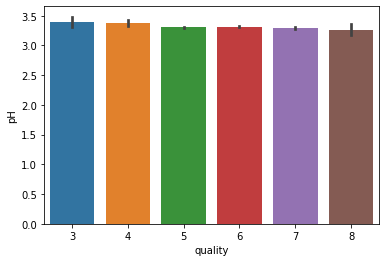

In [16]:
# 6i check how the quality is influenced by pH
# e.g., does higher quality mean higher pH?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['pH'])
print('ph has minimal effect on quality.')

quality increases with suphates.


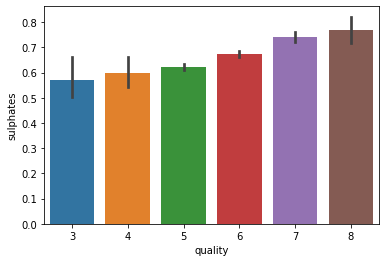

In [17]:
# 6j check how the quality is influenced by sulphates
# e.g., does higher quality mean higher sulphates?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['sulphates'])
print('quality increases with suphates.')

quality increases with alcohol.


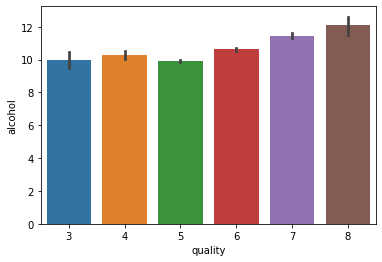

In [18]:
# 6k check how the quality is influenced by alcohol
# e.g., does higher quality mean higher alcohol percentage?
sns.barplot(x=red_wine_data['quality'], y=red_wine_data['alcohol'])
print('quality increases with alcohol.')

In [19]:
# 6l Correlation: check correlation between feature columns & target via correlation matrix
corr = red_wine_data.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


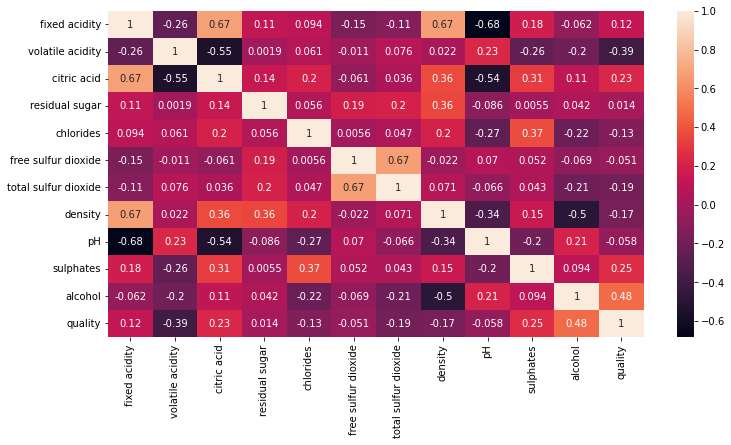

In [20]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True);

In [21]:
#7. Target: Check for discrete values
red_wine_data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

### Insights / Sanity Check Conclusions

1. **Shape and data sufficiency: Check if there are sufficient rows of data for an ML problem**
    1. **INSIGHT:** Shape of the data is (1599, 12). i.e., dataset contains ~1600 observations, which is much greater than number of columns (12). Hence we can apply ML techniques rather than statistical rule-based approach.


2. **Datatypes: Check whether all the columns in the given dataset is numeric**
    1. **INSIGHT:** `Dtype` indicates that all columns are numeric
    

3. **Missing Values: Check whether there are missing values**
    1. **INSIGHT:** `Non-Null Count` indicates there are no missing values in the dataset


4. **Zero-variance: Check if there are any zero variance column in the dataset**
    1. **INSIGHT:** No zero-variance columns found in the dataset


5. **Range of numbers in each column: Check the range of variation in each numeric column and apply scaling**
    1. **INSIGHT:** Scaling is required for each column


6. **Correlation: Check correlation between feature columns & target.** In the heatmap, check the correlation number for quality vs. feature. e.g., quality vs. pH = abs(-0.058) indicates very weak correlation between quality and pH.
    1. **INSIGHT:** The columns `pH`, `free sulfur dioxide`, `residual sugar` have very weak correlation (0.00 - 0.20)
    2. **INSIGHT:** The columns `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density` have weak correlation (0.20 - 0.40)
    3. **INSIGHT:** The remaining columns show strong correlation (0.40 and above)
    4. ***Note:*** *The barplots and correlation heatmap complement each other and reveal these findings*
    5. ***Note:*** *absolute values of correlations were considered*


7. **Other Observations:**
    1. **INSIGHT:** Since (a) the target is given (b) target is numeric (number between 0..10), we can conclude that this is a supervised linear regression problem
    2. **INSIGHT:** The target variable, i.e., `quality` has discrete values which indicates that this can be solved using classification methods also.


### EDA/Preprocessing
_(Based on the insights from the sanity check, we can now determine how to process the data.)_

#### Checklist of STANDARD EDA items

1. Strategy for missing data
    1. Action: No missing data, no action to be taken
    
    
2. Convert categorical to numeric
    1. Action: No Categorical data, no action to be taken
    
    
3. Dimensionality reduction/Drop the identified columns
    1. Action: Drop identified columns in Insights 6A and 6B
    
    
4. Check for Outliers, Check the range of variation in each numeric column and scale (*Optional*)
    1. Action: As per Insights 5A each numeric column needs to be scaled


### Approach for Developing ML Models
We will apply 4 machine learing methods - Linear Regression, Logistic Regression, Decision Tree and Random Forest. For each method, we will follow a 3-step approach as outlined below:

**Step 1: Develop the ML Model using all features**
1. First, we will process the complete dataset without dropping any columns.
2. We will build the ML model with the complete data, test and validate the predictions.

**Step 2: Develop the ML Model after dropping columns showing very weak correlations (0.0-0.2)**
1. As per Insights 6A, we will drop the columns that show very weak correlations. These columns are - `pH`, `free sulfur dioxide`, `residual sugar`
2. The dataset will thus have 9 features (including target)
3. We will build the ML model with the remaining data, test and validate the predictions

**Step 3: Develop the ML Model after dropping columns showing weak correlations (0.2-0.4)**
1. As per Insights 6B, we will next drop the columns that show weak correlations. These columns are - `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density`
2. The dataset will thus have 4 features (including target)
3. We will build the ML model with the remaining data, test and validate the predictions

**Step 4:**
1. Compare the Accuracy of all the three models developed
2. Choose the best model for deployment

**Conclusion**
1. Summarize the results of all 4 methods - consider only the best models

## Section 1: Linear Regression Models for Red Wine Quality

#### **Step 1: Develop the ML Model using all features**
1. First, we will process the complete dataset without dropping any columns.
2. We will build the ML model with the complete data, test and validate the predictions.

In [22]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [23]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [24]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Model 1 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Model 1 test shapes:')
print(X_test.shape, y_test.shape)

Model 1 train shapes:
(1279, 11) (1279,)

Model 1 test shapes:
(320, 11) (320,)


In [25]:
# create and fit a linear regression model
lm_red_wine1 = LinearRegression()
red_model1 = lm_red_wine1.fit(X_train, y_train)

In [26]:
# predict using X training dataset - i.e., X_train
train_predictions = red_model1.predict(X_train)
train_prediction = [int(round(x,0)) for x in train_predictions]

In [27]:
print('red wine model1: coeffs = ')
print(red_model1.coef_)
print()
print('red wine model1: intercept = ')
print(red_model1.intercept_)

red wine model1: coeffs = 
[ 0.04018122 -0.1792372  -0.0274236   0.00925231 -0.08499703  0.05884439
 -0.11984784 -0.0195308  -0.06076105  0.14253987  0.30030663]

red wine model1: intercept = 
5.629424674390097


In [28]:
# simple function to compare actual and predicted values i.e., MAPE
def compare_prediction(y, yhat):
    comp_matrix = pd.DataFrame(zip(y, yhat), columns = ['Actual', 'Predicted'])
    comp_matrix['Err'] = abs(comp_matrix['Actual']-comp_matrix['Predicted'])
    comp_matrix['PctErr'] = comp_matrix['Err']/comp_matrix['Actual'] * 100
    mean_value = np.mean(comp_matrix['PctErr'])
    return comp_matrix, mean_value

In [29]:
# compare actual and predicted values
comp_matrix, mean = compare_prediction(y_train, train_prediction)
print("Model 1 prediction comparison (training set):\n")
print(comp_matrix.head())

print("\nModel 1 mean error % (training set):", round(mean,2))

accuracy1 = round((100-mean),2)
print('Model1 accuracy (training set):', accuracy1)

Model 1 prediction comparison (training set):

   Actual  Predicted  Err  PctErr
0       6          6    0     0.0
1       6          6    0     0.0
2       6          6    0     0.0
3       5          5    0     0.0
4       5          5    0     0.0

Model 1 mean error % (training set): 8.06
Model1 accuracy (training set): 91.94


In [30]:
# predict using X_test dataset
test_preds = red_model1.predict(X_test)
test_preds = [int(round(x,0)) for x in test_preds]

In [31]:
# compare y_test and test_preds
test_cm, test_mean = compare_prediction(y=y_test, yhat=test_preds)
print("Model 1 prediction comparison (test set):\n")
print(comp_matrix.head())

print("\nModel 1 mean error % (test set):", round(mean,2))

accuracy1 = round((100-mean),2)
print('Model1 accuracy (test set) =', accuracy1)

Model 1 prediction comparison (test set):

   Actual  Predicted  Err  PctErr
0       6          6    0     0.0
1       6          6    0     0.0
2       6          6    0     0.0
3       5          5    0     0.0
4       5          5    0     0.0

Model 1 mean error % (test set): 8.06
Model1 accuracy (test set) = 91.94


#### ***Linear Regression Model 1 (using all features) shows a prediction accuracy of 91.94%***

#### **Step 2: Develop the ML Model after dropping columns showing very weak correlations (0.0-0.2)**
1. Drop the columns that show very weak correlations - `pH`, `free sulfur dioxide`, `residual sugar`
2. Build the ML model with the remaining data, test and validate the predictions

In [32]:
### 3. Dimensionality reduction/Drop the identified columns
lst = ['pH', 'free sulfur dioxide', 'residual sugar']
red_wine_data.drop(lst, axis =1, inplace = True)

In [33]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [34]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [35]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Model 2 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Model 2 test shapes:')
print(X_test.shape, y_test.shape)

Model 2 train shapes:
(1279, 8) (1279,)

Model 2 test shapes:
(320, 8) (320,)


In [36]:
# create and fit a linear regression model
lm_red_wine2 = LinearRegression()
red_model2 = lm_red_wine2.fit(X_train, y_train)

# computing yhat (ie train_predictions) using X (ie train_features)
train_predictions = red_model2.predict(X_train)
train_prediction = [int(round(x,0)) for x in train_predictions] 

In [37]:
print('red wine model2: coeffs = ')
print(red_model2.coef_)
print()
print('red wine model2: intercept = ')
print(red_model2.intercept_)

red wine model2: coeffs = 
[ 0.09389249 -0.18930018 -0.03417444 -0.07277841 -0.07042481 -0.04269329
  0.14615467  0.28690874]

red wine model2: intercept = 
5.62910433687724


In [38]:
# model 2: compare actual and predicted values
comp_matrix, mean = compare_prediction(y_train, train_prediction)
print("Model 2 prediction comparison (training set):\n")
print(comp_matrix.head())

print("\nModel 2 mean error % (training set):", round(mean,2))

accuracy2 = round((100-mean),2)
print('Model 2 accuracy (training set):', accuracy2)

Model 2 prediction comparison (training set):

   Actual  Predicted  Err  PctErr
0       6          6    0     0.0
1       6          6    0     0.0
2       6          6    0     0.0
3       5          5    0     0.0
4       5          5    0     0.0

Model 2 mean error % (training set): 8.08
Model 2 accuracy (training set): 91.92


In [39]:
# predict using X_test dataset
test_preds = red_model2.predict(X_test)
test_preds = [int(round(x,0)) for x in test_preds]

In [40]:
# compare y_test and test_preds
test_cm, test_mean = compare_prediction(y=y_test, yhat=test_preds)
print("Model 2 prediction comparison (test set):\n")
print(comp_matrix.head())

print("\nModel 2 mean error % (test set):", round(mean,2))

accuracy2 = round((100-mean),2)
print('Model 2 accuracy (test set) =', accuracy2)

Model 2 prediction comparison (test set):

   Actual  Predicted  Err  PctErr
0       6          6    0     0.0
1       6          6    0     0.0
2       6          6    0     0.0
3       5          5    0     0.0
4       5          5    0     0.0

Model 2 mean error % (test set): 8.08
Model 2 accuracy (test set) = 91.92


#### ***Linear Regression Model 2 (after dropping `pH`, `free sulfur dioxide`, `residual sugar`) shows a prediction accuracy of 91.92%***

#### **Step 3: Develop the ML Model after dropping columns showing weak correlations (0.2-0.4)**
1. Drop the columns that show weak correlations - `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density`
2. Build the ML model, test and validate the predictions.

In [41]:
### 3. Dimensionality reduction/Drop the identified columns
lst = ['fixed acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density']
red_wine_data.drop(lst, axis =1, inplace = True)

In [42]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [43]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [44]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Model 3 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Model 3 test shapes:')
print(X_test.shape, y_test.shape)

Model 3 train shapes:
(1279, 3) (1279,)

Model 3 test shapes:
(320, 3) (320,)


In [45]:
# create and fit a linear regression model
lm_red_wine3 = LinearRegression()
red_model3 = lm_red_wine3.fit(X_train, y_train)

# computing yhat (ie train_predictions) using X (ie train_features)
train_predictions = red_model3.predict(X_train)
train_prediction = [int(round(x,0)) for x in train_predictions]

In [46]:
# model 3: compare actual and predicted values
comp_matrix, mean = compare_prediction(y_train, train_prediction)
print("Model 3 prediction comparison (training set):\n")
print(comp_matrix.head())

print("\nModel 3 mean error % (training set):", round(mean,2))

accuracy3 = round((100-mean),2)
print('Model 3 accuracy (training set):', accuracy3)

Model 3 prediction comparison (training set):

   Actual  Predicted  Err  PctErr
0       6          6    0     0.0
1       6          6    0     0.0
2       6          6    0     0.0
3       5          5    0     0.0
4       5          5    0     0.0

Model 3 mean error % (training set): 8.14
Model 3 accuracy (training set): 91.86


In [47]:
# model 3: predict using X_test dataset
test_preds = red_model3.predict(X_test)
test_preds = [int(round(x,0)) for x in test_preds]

In [48]:
# model 3: compare y_test and test_preds
test_cm, test_mean = compare_prediction(y=y_test, yhat=test_preds)
print("Model 3 prediction comparison (test set):\n")
print(comp_matrix.head())

print("\nModel 3 mean error % (test set):", round(mean,2))

accuracy3 = round((100-mean),2)
print('Model 3 accuracy (test set) =', accuracy3)

Model 3 prediction comparison (test set):

   Actual  Predicted  Err  PctErr
0       6          6    0     0.0
1       6          6    0     0.0
2       6          6    0     0.0
3       5          5    0     0.0
4       5          5    0     0.0

Model 3 mean error % (test set): 8.14
Model 3 accuracy (test set) = 91.86


#### ***Linear Regression Model 3 makes predictions using only 3 columns - `volatile acidity`, `sulphates`, `alcohol` and shows a prediction accuracy of 91.86%***.
So far, we've dropped the following columns:

1. Model 2: `pH`, `free sulfur dioxide`, `residual sugar` were  dropped.
2. Model 3: `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density` were dropped.

#### Step 4: Compare the Accuracy of all the three models developed


In [49]:
print("Model1 Accuracy {}".format(accuracy1))
print("Model2 Accuracy {}".format(accuracy2))
print("Model3 Accuracy {}".format(accuracy3))

Model1 Accuracy 91.94
Model2 Accuracy 91.92
Model3 Accuracy 91.86


#### Choose the best model for deployment.

Since we are getting almost the same accuracy across models, Model 3 can be chosen as it has least number of features.

In [50]:
# note the linear regression accuracy here for the final comparison
lin_accuracy = accuracy3

#### Save the chosen model

In [51]:
# save red_model3 as per analysis
pickle_fname = 'linear_red_wine_model.pkl'
model_file = open(pickle_fname, 'wb')
pickle.dump(obj=red_model3, file=model_file)
model_file.close()

In [52]:
# reload the model from disk and check if it is saved properly.
model_file = open(pickle_fname, 'rb')
lr_model = pickle.load(model_file)
model_file.close()
print(lr_model)

LinearRegression()


# Section 2: Logistic Regression for Red Wine Quality

We've already done the sanity checks and EDA earlier. We only need to build various logistic regression models based on the correlations we've observed, and compare the accuracies obtained. We will also use K-fold technique to increase the prediction accuracy for each logistic regression model.

#### **Step 1: Develop the ML Model using all features**
1. First, we will process the complete dataset without dropping any columns.
2. We will build the ML model with the complete data, test and validate the predictions.

In [53]:
# refresh the red wine dataset
red_wine_data = pd.read_csv(fpath, delimiter =';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [54]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [55]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [56]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Logistic Regression: Model 1 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Logistic Regression: Model 1 test shapes:')
print(X_test.shape, y_test.shape)

Logistic Regression: Model 1 train shapes:
(1279, 11) (1279,)

Logistic Regression: Model 1 test shapes:
(320, 11) (320,)


In [57]:
# create and fit a logistic regression model
classifier = LogisticRegression(random_state=42, max_iter=200)  
classifier = classifier.fit(X_train, y_train)

In [58]:
print('Wine Quality Range: ({}, {})'.format(y.min(), y.max()))
print('\nLogistic Regression Model 1: coeffs =\n')
print(classifier.coef_)
print()
print('Logistic Regression Model 1: intercept =')
print(classifier.intercept_)

Wine Quality Range: (3, 8)

Logistic Regression Model 1: coeffs =

[[ 3.17507730e-01  1.12747345e+00  1.42632534e-01 -1.88643476e-01
   7.15051446e-01  3.72098191e-01 -7.57441134e-01  7.79892871e-01
   6.49671017e-01 -6.48408105e-01 -9.66823928e-01]
 [ 2.25501994e-01  2.96032502e-01 -2.05282453e-04  3.40754953e-01
   2.69454456e-01 -3.79885939e-01  2.77200893e-01 -6.90768359e-01
   4.21066845e-01 -2.19050235e-01 -6.26407829e-01]
 [-4.44851940e-01 -6.23841013e-03 -5.51615498e-02 -1.84418230e-01
   1.18346499e-01 -2.21474283e-01  7.86167818e-01  2.81661915e-01
  -1.83054250e-01 -3.07315738e-01 -5.65850067e-01]
 [-2.17566501e-01 -4.28805216e-01 -2.58377350e-01 -1.65326476e-01
   1.68933471e-03  8.20216986e-02  1.93375014e-01  2.07290930e-01
  -1.54955181e-01  8.07007060e-02  2.75148791e-01]
 [ 2.70974385e-01 -7.96120525e-01 -1.55366126e-01  1.95648707e-01
  -2.13449820e-01  8.54079083e-02 -1.66131997e-01 -3.24419883e-01
  -1.69300693e-02  5.22101398e-01  7.78933090e-01]
 [-1.51565668e-01 

In [59]:
# compute train_predictions using X_train
train_predictions = classifier.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 7)


In [60]:
#create a confusion matrix for training data set  
from sklearn.metrics import confusion_matrix  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,1,1,6,1,0,0
4,0,0,27,15,1,0
5,2,0,423,123,3,0
6,0,0,164,313,29,0
7,0,0,8,94,55,0
8,0,0,0,9,4,0


In [61]:
# compute test predictions using X_test
test_preds= classifier.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (4, 7)


In [62]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,1,7,2,0,0
5,0,0,98,32,0,0
6,0,0,46,76,10,0
7,0,0,3,30,9,0
8,0,0,0,1,4,0


In [63]:
log_train_score1 = classifier.score(X_train, y_train)
print('Train Accuracy Score', log_train_score1)

Train Accuracy Score 0.619233776387803


In [64]:
log_test_score1 = classifier.score(X_test, y_test)
print('Test Accuracy Score', log_test_score1)

Test Accuracy Score 0.575


#### Apply cross-validations to improve the model performance
1. Apply cross-validation
2. Apply k-fold cross validation

In [65]:
# obtain scores and corresponding estimators

# cross_validate returns the scores and also the underlying estimators
scores = cross_validate(classifier, X_train, y_train, cv=5, return_estimator=True)

# visually locate the estimator that has the maximum score.
# in this case, it is estimator[4] which gives 67% accuracy.
print(scores.keys())
print(scores['estimator'])
print(scores['test_score'])

# pick up the estimator that gives the most accurate prediction
# we can use the estimator to obtain predictions; we are not doing this here
estimator = scores['estimator'][4]


dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
(LogisticRegression(max_iter=200, random_state=42), LogisticRegression(max_iter=200, random_state=42), LogisticRegression(max_iter=200, random_state=42), LogisticRegression(max_iter=200, random_state=42), LogisticRegression(max_iter=200, random_state=42))
[0.5859375  0.58984375 0.5703125  0.6171875  0.67058824]


In [66]:
# 2. Apply K-fold cross validation
kfold = KFold(n_splits=5)

# cross_validate returns the scores and also the underlying estimators
results = cross_validate(classifier, X_train, y_train, cv=kfold, return_estimator=True)
print('K-fold scores:', results['test_score'])
print('Mean accuracy of k-fold scores:', round(results['test_score'].mean()*100,2))

# pick up the estimator that gives the most accurate prediction
# we can use the estimator to obtain predictions; we are not doing this here
estimator = results['estimator'][4]
score1_max = results['test_score'][4]
print('highest kfold score =', score1_max)

K-fold scores: [0.57421875 0.59765625 0.5625     0.6015625  0.6745098 ]
Mean accuracy of k-fold scores: 60.21
highest kfold score = 0.6745098039215687


#### Step 2: Develop the second Logistic Regression Model after dropping columns showing very weak correlations (0.0 - 0.2)
1. Drop `pH`, `free sulfur dioxide`, `residual sugar` columns.
2. Build the ML model, test and validate the predictions.

In [67]:
# refresh the red wine dataset
red_wine_data = pd.read_csv(fpath, delimiter =';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [68]:
### drop columns showing very weak correlations
lst = ['pH', 'free sulfur dioxide', 'residual sugar']
red_wine_data.drop(lst, axis =1, inplace = True)

In [69]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [70]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [71]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Logistic Regression: Model 2 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Logistic Regression: Model 2 test shapes:')
print(X_test.shape, y_test.shape)

Logistic Regression: Model 2 train shapes:
(1279, 8) (1279,)

Logistic Regression: Model 2 test shapes:
(320, 8) (320,)


In [72]:
# create and fit a Logistic regression model
classifier2 = LogisticRegression(random_state=42)  
classifier2 = classifier2.fit(X_train, y_train)

In [73]:
print('Wine Quality Range: ({}, {})'.format(y.min(), y.max()))
print('\nLogistic Regression Model 2: coeffs =\n')
print(classifier2.coef_)
print()
print('Logistic Regression Model 2: intercept =')
print(classifier2.intercept_)

Wine Quality Range: (3, 8)

Logistic Regression Model 2: coeffs =

[[-3.36508927e-02  1.15481688e+00 -1.74391019e-03  6.47904666e-01
  -5.71869798e-01  8.23847664e-01 -6.74644646e-01 -8.52096704e-01]
 [-3.95683427e-01  3.58367311e-01  8.47999430e-02  2.24373649e-01
   4.56073029e-02 -1.29683680e-01 -3.20750585e-01 -2.92978488e-01]
 [-1.54082631e-01  1.58117836e-02 -4.63289630e-02  1.24107152e-01
   6.15356983e-01  9.53084031e-04 -2.65110874e-01 -7.53054714e-01]
 [ 2.84554421e-02 -4.58275691e-01 -3.15182962e-01  1.81689506e-02
   2.43189558e-01 -1.50085843e-02  1.18927533e-01  1.49149516e-01]
 [ 2.34272289e-01 -8.40928072e-01 -1.78930102e-01 -2.12215461e-01
  -9.78361695e-02 -1.87939445e-01  5.04624654e-01  8.45163819e-01]
 [ 3.20689220e-01 -2.29792207e-01  4.57385994e-01 -8.02338957e-01
  -2.34447876e-01 -4.92169039e-01  6.36953918e-01  9.03816570e-01]]

Logistic Regression Model 2: intercept =
[-3.52670881 -0.01590016  2.58444082  2.72554169  0.61772236 -2.38509589]


In [74]:
# compute train_predictions using X_train
train_predictions = classifier2.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 7)


In [75]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,1,0,7,1,0,0
4,0,0,28,15,0,0
5,2,0,417,131,1,0
6,0,0,169,311,26,0
7,0,0,10,99,48,0
8,0,0,0,9,4,0


In [76]:
# compute test predictions using X_test
test_preds= classifier2.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 7)


In [77]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,8,2,0,0
5,0,0,100,29,1,0
6,0,0,46,76,10,0
7,0,0,3,31,8,0
8,0,0,0,1,4,0


In [78]:
score = classifier2.score(X_train, y_train)
print('Train Accuracy Score', score)

Train Accuracy Score 0.6075058639562158


In [79]:
score2 = classifier2.score(X_test, y_test)
print('Test Accuracy Score', score)

Test Accuracy Score 0.6075058639562158


#### Apply cross-validations to improve the model performance
1. Apply cross-validation
2. Apply k-fold cross validation

In [80]:
# obtain scores and corresponding estimators

# cross_validate returns the scores and also the underlying estimators
scores = cross_validate(classifier2, X_train, y_train, cv=5, return_estimator=True)

# visually locate the estimator that has the maximum score.
# in this case, it is estimator[4] which gives 67% accuracy.
print(scores.keys())
print(scores['estimator'])
print(scores['test_score'])

# pick up the estimator that gives the most accurate prediction
# we can use the estimator to obtain predictions; we are not doing this here
estimator = scores['estimator'][4]


dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
(LogisticRegression(random_state=42), LogisticRegression(random_state=42), LogisticRegression(random_state=42), LogisticRegression(random_state=42), LogisticRegression(random_state=42))
[0.578125   0.58203125 0.57421875 0.625      0.65882353]


In [81]:
# 2. Apply K-fold cross validation
kfold = KFold(n_splits=5)

# cross_validate returns the scores and also the underlying estimators
results = cross_validate(classifier2, X_train, y_train, cv=kfold, return_estimator=True)
print('K-fold scores:', results['test_score'])
print('Mean accuracy of k-fold scores:', round(results['test_score'].mean()*100,2))

# pick up the estimator that gives the most accurate prediction
# we can use the estimator to obtain predictions; we are not doing this here
estimator = results['estimator'][4]
scores2_max = scores['test_score'][4]
print('logistic regression model 2: highest kfold score =', scores2_max)

K-fold scores: [0.56640625 0.59765625 0.57421875 0.6171875  0.65882353]
Mean accuracy of k-fold scores: 60.29
logistic regression model 2: highest kfold score = 0.6588235294117647


#### Step 3: Develop the third Logistic Regression Model - after dropping columns showing weak correlations (0.2 - 0.4)
1. Drop columns `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density`.
2. Build the ML model, test and validate the predictions.

In [82]:
### 3. Drop the columns showing weak correlations
lst = ['fixed acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density']
red_wine_data.drop(lst, axis =1, inplace = True)

In [83]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [84]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [85]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Logistic Regression: Model 3 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Logistic Regression: Model 3 test shapes:')
print(X_test.shape, y_test.shape)

Logistic Regression: Model 3 train shapes:
(1279, 3) (1279,)

Logistic Regression: Model 3 test shapes:
(320, 3) (320,)


In [86]:
# create and fit a logistic regression model
classifier3 = LogisticRegression(random_state=42)  
classifier3 = classifier3.fit(X_train, y_train)

In [87]:
print('Wine Quality Range: ({}, {})'.format(y.min(), y.max()))
print('\nLogistic Regression Model 3: coeffs =\n')
print(classifier3.coef_)
print()
print('Logistic Regression Model 3: intercept =')
print(classifier3.intercept_)

Wine Quality Range: (3, 8)

Logistic Regression Model 3: coeffs =

[[ 1.17996622 -0.20575491 -0.92483039]
 [ 0.45640416 -0.29450005 -0.23664581]
 [ 0.12035703 -0.22764997 -0.90260972]
 [-0.27349158  0.02033144  0.09920038]
 [-0.85980234  0.30917349  0.86845164]
 [-0.62343347  0.39840001  1.0964339 ]]

Logistic Regression Model 3: intercept =
[-2.82805638 -0.21744754  2.29951555  2.44377325  0.475164   -2.17294887]


In [88]:
# compute train_predictions using X_train
train_predictions = classifier3.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 7)


In [89]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,1,0,7,1,0,0
4,0,0,30,13,0,0
5,0,0,410,139,2,0
6,0,0,193,290,23,0
7,0,0,14,105,38,0
8,0,0,0,10,3,0


In [90]:
# compute test predictions using X_test
test_preds= classifier3.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 7)


In [91]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,10,0,0,0
5,0,0,103,26,1,0
6,0,0,56,67,9,0
7,0,0,3,31,8,0
8,0,0,0,1,4,0


In [92]:
score = classifier3.score(X_train, y_train)
print('Train Accuracy Score', score)

Train Accuracy Score 0.5777951524628616


In [93]:
score3 = classifier3.score(X_test, y_test)
print('Test Accuracy Score', score)

Test Accuracy Score 0.5777951524628616


#### Apply cross-validations to improve the model performance
1. Apply cross-validation
2. Apply k-fold cross validation

In [94]:
# obtain scores and corresponding estimators

# cross_validate returns the scores and also the underlying estimators
scores = cross_validate(classifier3, X_train, y_train, cv=5, return_estimator=True)

# visually locate the estimator that has the maximum score.
# in this case, it is estimator[4] which gives 67% accuracy.
print(scores.keys())
print(scores['estimator'])
print(scores['test_score'])

# pick up the estimator that gives the most accurate prediction
# we can use the estimator to obtain predictions; we are not doing this here
estimator = scores['estimator'][4]


dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])
(LogisticRegression(random_state=42), LogisticRegression(random_state=42), LogisticRegression(random_state=42), LogisticRegression(random_state=42), LogisticRegression(random_state=42))
[0.53515625 0.52734375 0.5625     0.59765625 0.64705882]


In [95]:
# 2. Apply K-fold cross validation
kfold = KFold(n_splits=5)

# cross_validate returns the scores and also the underlying estimators
results = cross_validate(classifier3, X_train, y_train, cv=kfold, return_estimator=True)
print('K-fold scores:', results['test_score'])
print('Mean accuracy of k-fold scores:', round(results['test_score'].mean()*100,2))

# pick up the estimator that gives the most accurate prediction
# we can use the estimator to obtain predictions; we are not doing this here
estimator = results['estimator'][4]
estimator = results['estimator'][4]
scores3_max = scores['test_score'][4]
print('logistic regression model 3: highest kfold score =', scores3_max)

K-fold scores: [0.53515625 0.57421875 0.546875   0.58984375 0.64313725]
Mean accuracy of k-fold scores: 57.78
logistic regression model 3: highest kfold score = 0.6470588235294118


In [96]:
# compare accuracy of all logistic regression models
print("Model1 Accuracy {}".format(score1_max))
print("Model2 Accuracy {}".format(scores2_max))
print("Model3 Accuracy {}".format(scores3_max))

Model1 Accuracy 0.6745098039215687
Model2 Accuracy 0.6588235294117647
Model3 Accuracy 0.6470588235294118


#### Choose the best model for deployment.

Since we are getting highest accuracy for model1, we are going for model1.

In [97]:
# note the accuracy for final comparison
log_accuracy = score1_max

In [98]:
# save red_model1 as per analysis
fname = 'log_red_wine_model.pkl'
model_file = open(fname, 'wb')
pickle.dump(obj=classifier, file=model_file)
model_file.close()

In [99]:
# reload the model from disk and check if it is saved
model_file = open(fname, 'rb')
logistic_model = pickle.load(model_file)
model_file.close()
print(logistic_model)

LogisticRegression(max_iter=200, random_state=42)


## Section 3: Decision Tree for Red Wine Quality

We've already done the sanity checks and EDA earlier. We only need to build various decision tree models based on the correlations we've observed, and compare the accuracies obtained.

In [100]:
# refresh the red wine dataset
red_wine_data = pd.read_csv(fpath, delimiter =';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Step 1: Develop the first Decision Tree Model using all the features
Build the ML model with the complete data, test and validate the predictions.

In [101]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [102]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
object = StandardScaler()
X = object.fit_transform(X)

In [103]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Decison Tree: Model 1 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Decision Tree: Model 1 test shapes:')
print(X_test.shape, y_test.shape)

Decison Tree: Model 1 train shapes:
(1279, 11) (1279,)

Decision Tree: Model 1 test shapes:
(320, 11) (320,)


In [104]:
# create and fit a Decision tree model
classifier = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3, min_samples_leaf=5)
classifier = classifier.fit(X_train,y_train)

In [105]:
# compute train_predictions using X_train
train_predictions = classifier.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (5, 7)


In [106]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,9,0,0,0
4,0,0,37,6,0,0
5,0,0,499,50,2,0
6,0,0,282,197,27,0
7,0,0,35,68,54,0
8,0,0,2,4,7,0


In [107]:
# compute test predictions using X_test
test_preds= classifier.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 7)


In [108]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,8,2,0,0
5,0,0,118,11,1,0
6,0,0,82,41,9,0
7,0,0,9,23,10,0
8,0,0,0,1,4,0


In [109]:
dt_accuracy1_train = accuracy_score(y_train, train_predictions)
dt_accuracy1_test = accuracy_score(y_test, test_preds)
print('training accuracy: {}'.format(dt_accuracy1_train))
print('test accuracy: {}'.format(dt_accuracy1_test))

training accuracy: 0.5863956215793589
test accuracy: 0.528125


#### Visualize Model 1 - Decision Tree 

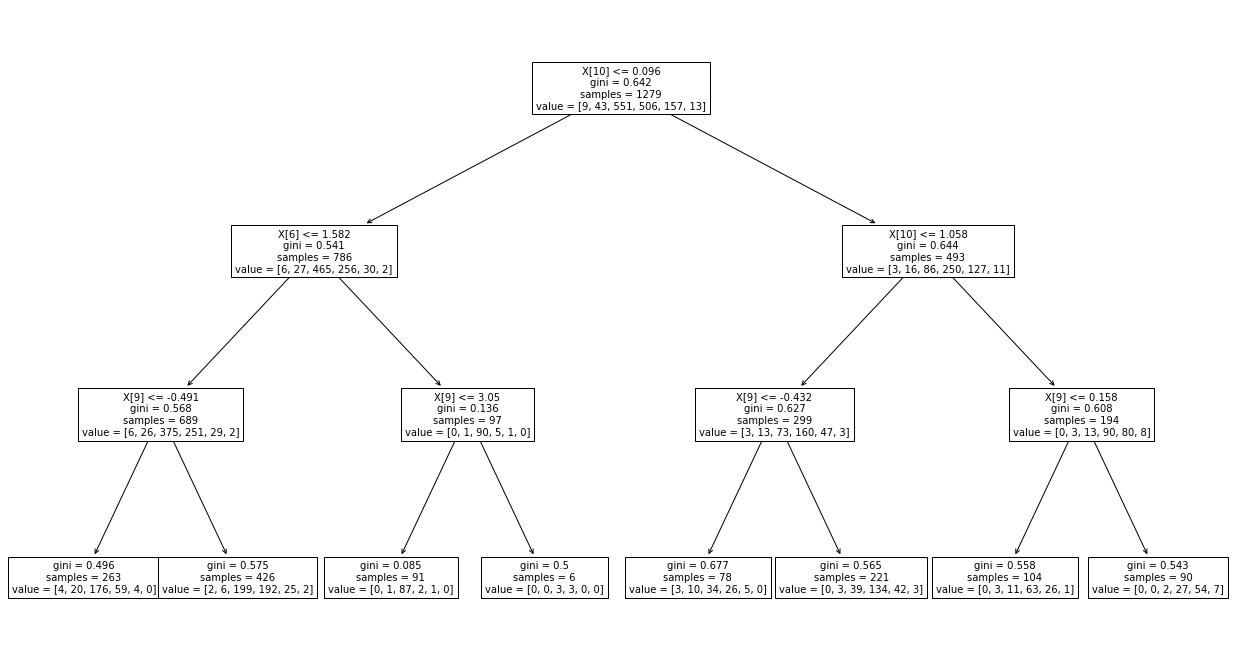

In [110]:
fig, ax = plt.subplots(figsize=(22, 12))
tree.plot_tree(classifier, fontsize=10)
plt.show()

#### Step 2: Develop the second Decision Tree Model after dropping columns showing very weak correlations (0.0 - 0.2)
1. Drop `pH`, `free sulfur dioxide`, `residual sugar` columns.
2. Build the ML model, test and validate the predictions.

In [111]:
### drop columns showing very weak correlations
lst = ['pH', 'free sulfur dioxide', 'residual sugar']
red_wine_data.drop(lst, axis =1, inplace = True)

In [112]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [113]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [114]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Decision Tree: Model 2 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Decision Tree: Model 2 test shapes:')
print(X_test.shape, y_test.shape)

Decision Tree: Model 2 train shapes:
(1279, 8) (1279,)

Decision Tree: Model 2 test shapes:
(320, 8) (320,)


In [115]:
# create and fit a Decision tree model
classifier2 = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   
classifier2 = classifier2.fit(X_train,y_train)

In [116]:
# compute train_predictions using X_train
train_predictions = classifier2.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (5, 7)


In [117]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,9,0,0,0
4,0,0,37,6,0,0
5,0,0,499,50,2,0
6,0,0,282,197,27,0
7,0,0,35,68,54,0
8,0,0,2,4,7,0


In [118]:
# compute test predictions using X_test
test_preds= classifier2.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 7)


In [119]:
#create a confusion matrix for test data set  
cm = confusion_matrix(y_test, test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm, columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,8,2,0,0
5,0,0,118,11,1,0
6,0,0,82,41,9,0
7,0,0,9,23,10,0
8,0,0,0,1,4,0


In [120]:
dt_accuracy2_train = accuracy_score(y_train, train_predictions)
dt_accuracy2_test = accuracy_score(y_test, test_preds)
print('training accuracy: {}'.format(dt_accuracy2_train))
print('test accuracy: {}'.format(dt_accuracy2_test))

training accuracy: 0.5863956215793589
test accuracy: 0.528125


#### Visualize Model 2 - Decision Tree 

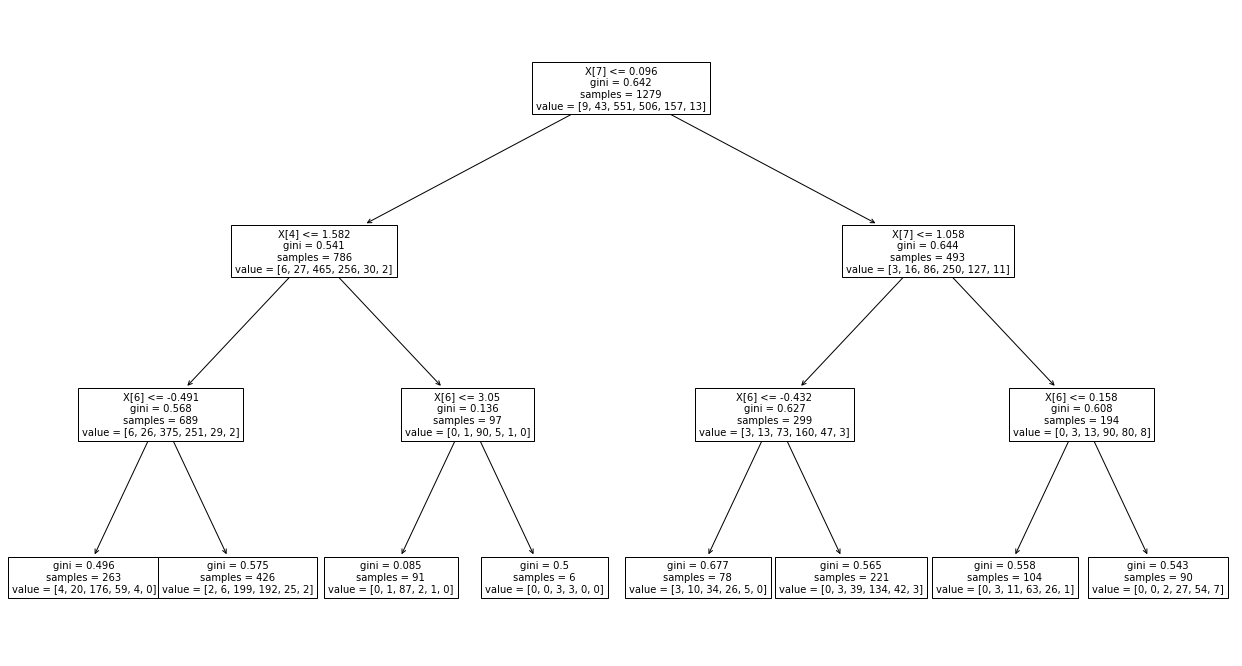

In [121]:
fig, ax = plt.subplots(figsize=(22, 12))
tree.plot_tree(classifier2, fontsize=10)
plt.show()

#### Step 3: Develop the third Decision Tree Model - after dropping columns showing weak correlations (0.2 - 0.4)
1. Drop columns `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density`
2. Build the ML model, test and validate the predictions.



In [122]:
### drop columns showing weak correlations
lst = ['fixed acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density']
red_wine_data.drop(lst, axis =1, inplace = True)

In [123]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [124]:
#Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [125]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Decision Tree: Model 3 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Decision Tree: Model 3 test shapes:')
print(X_test.shape, y_test.shape)

Decision Tree: Model 3 train shapes:
(1279, 3) (1279,)

Decision Tree: Model 3 test shapes:
(320, 3) (320,)


In [126]:
# create and fit a Decision tree model
classifier3 = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   
classifier3 = classifier3.fit(X_train,y_train)

In [127]:
# compute train_predictions using X_train
train_predictions = classifier3.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (5, 7)


In [128]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,9,0,0,0
4,0,0,36,7,0,0
5,0,0,466,83,2,0
6,0,0,222,257,27,0
7,0,0,21,82,54,0
8,0,0,0,6,7,0


In [129]:
# compute test predictions using X_test
test_preds= classifier3.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 7)


In [130]:
#create a confusion matrix for test data set  
cm = confusion_matrix(y_test, test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm, columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,8,2,0,0
5,0,0,107,22,1,0
6,0,0,63,60,9,0
7,0,0,5,27,10,0
8,0,0,0,1,4,0


In [131]:
dt_accuracy3_train = accuracy_score(y_train, train_predictions)
dt_accuracy3_test = accuracy_score(y_test, test_preds)
print('training accuracy: {}'.format(dt_accuracy3_train))
print('test accuracy: {}'.format(dt_accuracy3_test))

training accuracy: 0.6075058639562158
test accuracy: 0.553125


#### Visualize Model 3 - Decision Tree 

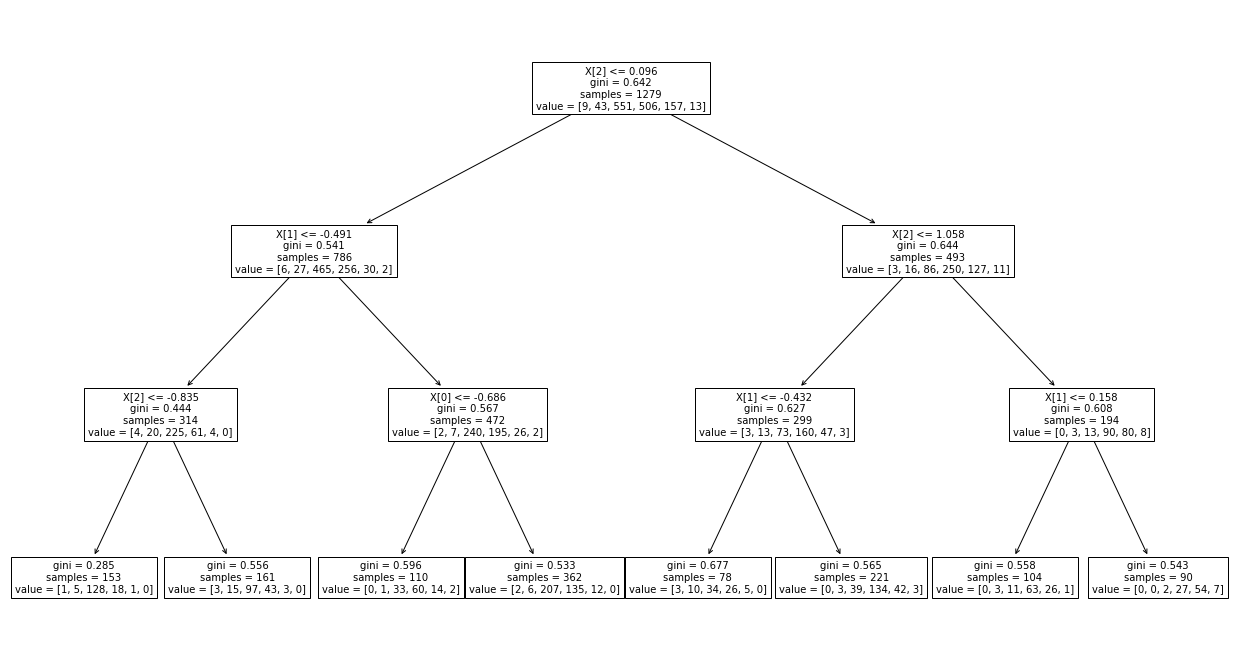

In [132]:
fig, ax = plt.subplots(figsize=(22, 12))
tree.plot_tree(classifier3, fontsize=10)
plt.show()

In [133]:
# compare the accuracy of the 3 models
print('Model 1 Accuracy:')
print('\ttraining accuracy: {}'.format(dt_accuracy1_train))
print('\ttest accuracy: {}'.format(dt_accuracy1_test))
print()
print('Model 2 Accuracy:')
print('\ttraining accuracy: {}'.format(dt_accuracy2_train))
print('\ttest accuracy: {}'.format(dt_accuracy2_test))
print()
print('Model 3 Accuracy:')
print('\ttraining accuracy: {}'.format(dt_accuracy3_train))
print('\ttest accuracy: {}'.format(dt_accuracy3_test))

Model 1 Accuracy:
	training accuracy: 0.5863956215793589
	test accuracy: 0.528125

Model 2 Accuracy:
	training accuracy: 0.5863956215793589
	test accuracy: 0.528125

Model 3 Accuracy:
	training accuracy: 0.6075058639562158
	test accuracy: 0.553125


In [134]:
dtree_accuracy = dt_accuracy3_test
dtree_accuracy

0.553125

In [135]:
# compare accuracy of all decision tree models
print("Accuracy of Decision Tree Models on test set:")
print("Model1 Accuracy {}".format(dt_accuracy1_test))
print("Model2 Accuracy {}".format(dt_accuracy2_test))
print("Model3 Accuracy {}".format(dt_accuracy3_test))

Accuracy of Decision Tree Models on test set:
Model1 Accuracy 0.528125
Model2 Accuracy 0.528125
Model3 Accuracy 0.553125


#### Choose the best model for deployment.

Since we are getting highest accuracy for model3, we are going for model3

In [136]:
# save red_model3 as per analysis
fname = 'dtree_red_wine_model.pkl'
model_file = open(fname, 'wb')
pickle.dump(obj=classifier3, file=model_file)
model_file.close()

In [137]:
# reload the model from disk and check if it is saved properly.
model_file = open(fname, 'rb')
decision_model = pickle.load(model_file)
model_file.close()
print(decision_model)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)


## Section 4: Random Forest for Red Wine Quality

We've already done the sanity checks and EDA earlier. We only need to build various Random Forest models based on the correlations we've observed, and compare the accuracies obtained.

In [138]:
# refresh the red wine dataset
red_wine_data = pd.read_csv(fpath, delimiter =';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Step 1: Develop the first Random Forest Model using all the features
Build the ML model with the complete data, test and validate the predictions.

In [139]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [140]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
object = StandardScaler()
X = object.fit_transform(X)

In [141]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Random Forest: Model 1 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Random Forest: Model 1 test shapes:')
print(X_test.shape, y_test.shape)

Random Forest: Model 1 train shapes:
(1279, 11) (1279,)

Random Forest: Model 1 test shapes:
(320, 11) (320,)


In [142]:
# create and fit a Random Forest model
classifier = RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier = classifier.fit(X_train, y_train)  

In [143]:
# compute train_predictions using X_train
train_predictions = classifier.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 8)


In [144]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,9,0,0,0,0,0
4,0,40,3,0,0,0
5,0,0,547,4,0,0
6,0,0,9,497,0,0
7,0,0,1,5,151,0
8,0,0,0,1,1,11


In [145]:
# compute test predictions using X_test
test_preds= classifier.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (4, 7)


In [146]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,0,1,0,0
4,0,0,6,4,0,0
5,0,1,98,29,2,0
6,0,0,38,88,6,0
7,0,1,1,20,20,0
8,0,0,0,1,4,0


In [147]:
rf_accuracy1_train = accuracy_score(y_train, train_predictions)
rf_accuracy1_test = accuracy_score(y_test, test_preds)
print('training accuracy: {}'.format(rf_accuracy1_train))
print('test accuracy: {}'.format(rf_accuracy1_test))

training accuracy: 0.9812353401094606
test accuracy: 0.64375


##### Try increasing the accuracy through GridSearchCV

In [148]:
# define gridsearchcv configuration params
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8,9,10,11],
    'criterion' :['gini', 'entropy']
}

# fit the training dataset via grid search
CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9, 10, 11],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [149]:
best_params = CV_rfc.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


In [150]:
classifier = CV_rfc.best_estimator_
train_predictions = classifier.predict(X_train)

In [151]:
# compute train_predictions using X_train
train_predictions = classifier.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 8)


In [152]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,9,0,0,0,0,0
4,0,41,2,0,0,0
5,0,0,549,2,0,0
6,0,0,27,479,0,0
7,0,0,4,4,149,0
8,0,0,0,0,0,13


In [153]:
# compute test predictions using X_test
test_preds= classifier.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 8)


In [154]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,7,3,0,0
5,0,0,102,28,0,0
6,0,0,39,86,7,0
7,0,0,0,19,22,1
8,0,0,0,1,4,0


In [155]:
print('compare rf and gs accuracy:\n')
print('rf1 training accuracy: {}'.format(rf_accuracy1_train))
print('rf1 test accuracy: {}'.format(rf_accuracy1_test))
print()
gs_accuracy1_train = accuracy_score(y_train, train_predictions)
gs_accuracy1_test = accuracy_score(y_test, test_preds)
print('gs1 training accuracy: {}'.format(gs_accuracy1_train))
print('gs1 test accuracy: {}'.format(gs_accuracy1_test))


compare rf and gs accuracy:

rf1 training accuracy: 0.9812353401094606
rf1 test accuracy: 0.64375

gs1 training accuracy: 0.9695074276778733
gs1 test accuracy: 0.65625


#### Step 2: Develop the second Random Forest Model after dropping columns showing very weak correlations (0.0 - 0.2)
1. Drop `pH`, `free sulfur dioxide`, `residual sugar` columns.
2. Build the ML model, test and validate the predictions.

In [156]:
### drop columns showing very weak correlations
lst = ['pH', 'free sulfur dioxide', 'residual sugar']
red_wine_data.drop(lst, axis =1, inplace = True)

In [157]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [158]:
#Feature Scaling
object = StandardScaler()
X = object.fit_transform(X)

In [159]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Random Forest: Model 2 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Random Forest: Model 2 test shapes:')
print(X_test.shape, y_test.shape)

Random Forest: Model 2 train shapes:
(1279, 8) (1279,)

Random Forest: Model 2 test shapes:
(320, 8) (320,)


In [160]:
# create and fit a Random Forest model
classifier2 = RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier2 = classifier2.fit(X_train, y_train)  

In [161]:
# compute train_predictions using X_train
train_predictions = classifier2.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 8)


In [162]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,9,0,0,0,0,0
4,0,43,0,0,0,0
5,0,0,550,1,0,0
6,0,0,8,498,0,0
7,0,0,0,4,153,0
8,0,0,0,1,0,12


In [163]:
# compute test predictions using X_test
test_preds= classifier2.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (4, 7)


In [164]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,0,1,0,0
4,0,2,6,2,0,0
5,0,1,103,25,1,0
6,0,2,39,85,6,0
7,0,1,1,21,19,0
8,0,0,0,3,2,0


In [165]:
rf_accuracy2_train = accuracy_score(y_train, train_predictions)
rf_accuracy2_test = accuracy_score(y_test, test_preds)
print('training accuracy: {}'.format(rf_accuracy2_train))
print('test accuracy: {}'.format(rf_accuracy2_test))

training accuracy: 0.9890539483971853
test accuracy: 0.653125


##### Try increasing the accuracy through GridSearchCV

In [166]:
# define gridsearchcv configuration params
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8,9,10,11],
    'criterion' :['gini', 'entropy']
}

# fit the training dataset via grid search
CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                              max_features='sqrt',
                                              n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9, 10, 11],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [167]:
best_params = CV_rfc.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 200}


In [168]:
classifier2 = CV_rfc.best_estimator_
train_predictions = classifier2.predict(X_train)

In [169]:
# compute train_predictions using X_train
train_predictions = classifier2.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 8)


In [170]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,8,0,1,0,0,0
4,0,36,7,0,0,0
5,0,0,547,4,0,0
6,0,0,14,492,0,0
7,0,0,4,5,148,0
8,0,0,0,0,0,13


In [171]:
# compute test predictions using X_test
test_preds= classifier2.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 8)


In [172]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,7,3,0,0
5,0,0,101,28,1,0
6,0,0,32,94,6,0
7,0,0,0,21,20,1
8,0,0,0,1,4,0


In [173]:
print('compare rf and gs accuracy:\n')
print('rf2 training accuracy: {}'.format(rf_accuracy2_train))
print('rf2 test accuracy: {}'.format(rf_accuracy2_test))
print()
gs_accuracy2_train = accuracy_score(y_train, train_predictions)
gs_accuracy2_test = accuracy_score(y_test, test_preds)
print('gs2 training accuracy: {}'.format(gs_accuracy2_train))
print('gs2 test accuracy: {}'.format(gs_accuracy2_test))


compare rf and gs accuracy:

rf2 training accuracy: 0.9890539483971853
rf2 test accuracy: 0.653125

gs2 training accuracy: 0.9726348709929633
gs2 test accuracy: 0.671875


#### Step 3: Develop the third Random Forest Model after dropping columns showing weak correlations (0.2 - 0.4)

1. Drop columns `fixed acidity`, `citric acid`, `chlorides`, `total sulfur dioxide`, `density`
2. Build the ML model, test and validate the predictions.

In [174]:
### drop columns showing weak correlations
lst = ['fixed acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density']
red_wine_data.drop(lst, axis =1, inplace = True)

In [175]:
# create the "features and target" data sets
X = red_wine_data.drop('quality',axis=1)
y = red_wine_data['quality']

In [176]:
#Feature Scaling
object = StandardScaler()
X = object.fit_transform(X)

In [177]:
# split the features and target data sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Random Forest: Model 2 train shapes:')
print(X_train.shape, y_train.shape)
print()
print('Random Forest: Model 2 test shapes:')
print(X_test.shape, y_test.shape)

Random Forest: Model 2 train shapes:
(1279, 3) (1279,)

Random Forest: Model 2 test shapes:
(320, 3) (320,)


In [178]:
# create and fit a Random Forest model
classifier3 = RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier3 = classifier3.fit(X_train, y_train)  

In [179]:
# compute train_predictions using X_train
train_predictions = classifier3.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 8)


In [180]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,8,0,1,0,0,0
4,0,41,1,1,0,0
5,0,0,544,6,1,0
6,0,0,16,489,0,1
7,0,0,1,8,148,0
8,0,0,0,1,1,11


In [181]:
# compute test predictions using X_test
test_preds= classifier3.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (3, 7)


In [182]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,7,3,0,0
5,0,1,104,22,3,0
6,1,2,43,72,14,0
7,0,0,3,16,23,0
8,0,0,0,2,3,0


In [183]:
rf_accuracy3_train = accuracy_score(y_train, train_predictions)
rf_accuracy3_test = accuracy_score(y_test, test_preds)
print('training accuracy: {}'.format(rf_accuracy3_train))
print('test accuracy: {}'.format(rf_accuracy3_test))

training accuracy: 0.9702892885066459
test accuracy: 0.621875


##### Try increasing the accuracy through GridSearchCV

In [184]:
# define gridsearchcv configuration params
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8,9,10,11],
    'criterion' :['gini', 'entropy']
}

# fit the training dataset via grid search
CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                              max_features='sqrt',
                                              n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9, 10, 11],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [185]:
best_params = CV_rfc.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 500}


In [186]:
classifier2 = CV_rfc.best_estimator_
train_predictions = classifier2.predict(X_train)

In [187]:
# compute train_predictions using X_train
train_predictions = classifier2.predict(X_train)
print('Actual training data set quality range: ({}, {})'.format(y_train.min(), y_train.max()))
print('Predicted training data set quality range: ({}, {})'.format(train_predictions.min(), train_predictions.max()))

Actual training data set quality range: (3, 8)
Predicted training data set quality range: (3, 8)


In [188]:
#create a confusion matrix for training data set  
cm= confusion_matrix(y_train,train_predictions)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,9,0,0,0,0,0
4,0,41,2,0,0,0
5,0,0,546,4,1,0
6,0,0,33,471,1,1
7,0,0,2,6,149,0
8,0,0,0,0,0,13


In [189]:
# compute test predictions using X_test
test_preds= classifier2.predict(X_test)
print('Actual test data set quality range: ({}, {})'.format(y_test.min(), y_test.max()))
print('Predicted test data set quality range: ({}, {})'.format(test_preds.min(), test_preds.max()))

Actual test data set quality range: (3, 8)
Predicted test data set quality range: (5, 8)


In [190]:
#create a confusion matrix for test data set  
cm= confusion_matrix(y_test,test_preds)  
coords = [x for x in range(3,9)]
cm = pd.DataFrame(cm,columns=coords, index=coords )
cm

,3,4,5,6,7,8
3,0,0,1,0,0,0
4,0,0,6,4,0,0
5,0,0,104,25,1,0
6,0,0,45,77,10,0
7,0,0,3,16,22,1
8,0,0,0,2,3,0


In [191]:
print('compare rf and gs accuracy:\n')
print('rf3 training accuracy: {}'.format(rf_accuracy3_train))
print('rf3 test accuracy: {}'.format(rf_accuracy3_test))
print()
gs_accuracy3_train = accuracy_score(y_train, train_predictions)
gs_accuracy3_test = accuracy_score(y_test, test_preds)
print('gs3 training accuracy: {}'.format(gs_accuracy3_train))
print('gs3 test accuracy: {}'.format(gs_accuracy3_test))


compare rf and gs accuracy:

rf3 training accuracy: 0.9702892885066459
rf3 test accuracy: 0.621875

gs3 training accuracy: 0.9609069585613761
gs3 test accuracy: 0.634375


In [192]:
#### Step 4: Compare the Accuracy of all the three models developed
print('Model 1 Accuracy:')
print('\ttraining accuracy: {}'.format(rf_accuracy1_train))
print('\ttest accuracy: {}'.format(rf_accuracy1_test))
print()
print('Model 2 Accuracy:')
print('\ttraining accuracy: {}'.format(rf_accuracy2_train))
print('\ttest accuracy: {}'.format(rf_accuracy2_test))
print()
print('Model 3 Accuracy:')
print('\ttraining accuracy: {}'.format(rf_accuracy3_train))
print('\ttest accuracy: {}'.format(rf_accuracy3_test))

Model 1 Accuracy:
	training accuracy: 0.9812353401094606
	test accuracy: 0.64375

Model 2 Accuracy:
	training accuracy: 0.9890539483971853
	test accuracy: 0.653125

Model 3 Accuracy:
	training accuracy: 0.9702892885066459
	test accuracy: 0.621875


#### Choose the best model for deployment.

Since we are getting almost the same accuracy across models, Model 1

In [193]:
# save red_model1 as per analysis
fname = 'rf_red_wine_model.pkl'
model_file = open(fname, 'wb')
pickle.dump(obj=classifier, file=model_file)
model_file.close()

In [194]:
# reload the model from disk and check if it is saved properly.
model_file = open(fname, 'rb')
Random_Forest_model = pickle.load(model_file)
model_file.close()
print(Random_Forest_model)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       n_estimators=200)


In [195]:
#note the accuracy for final comparison
rf_accuracy = gs_accuracy1_test

### Comparing the accuracies  we got using 4 ML algorithms

In [196]:
print("Best accuracy using Linear Regression is {}".format(lin_accuracy))
print("Best accuracy using Logistic Regression is {}".format(log_accuracy))
print("Best accuracy using Decision Tree is {}".format(dtree_accuracy))
print("Best accuracy using Random Forest is {}".format(rf_accuracy ))


Best accuracy using Linear Regression is 91.86
Best accuracy using Logistic Regression is 0.6745098039215687
Best accuracy using Decision Tree is 0.553125
Best accuracy using Random Forest is 0.65625


## Conclusions
Three Models were developed for each ML Method:

1. considering all the features, 
2. dropping features showing very weak correlations (0.0-0.2)
3. dropping features showing weak correlations (0.2-0.4)

#### Linear Regression 

All models demonstrated more than 90% accuracy

#### Logistic Regression
Accuracy exhibited by all three models - between 57-60%. Using K-Fold the accuracy increased to between 65-67%

#### Decision Tree

Very poor accuracy exhibited by all three models - between 52-55%

#### Random Forest

Random forest Performed very well on training data with 98% to 99% accuracy but did not give good results with test dataset - accuracy was observed to be between 60-64%. Grid search CV gave 62-65% accuracy across models